For the analysis that we had created before, Ricardo and I had noticed that there were some discrepancies in the generation of the descriptive statistics. 

The calculations were being performed properly, however, the dataset that we were using was spread out over too large of an area (Bueno Aires is an area of 200 km$^2$, whereas Sydney's Urban Centre Locality was 3,483 km$^2$. We decided to do the following: 

1. Create a new dataframe that aggregates the data by the hex-ID
2. Perform a spatial join with the newly generated groupby dataframe and then aggregate the statistics from that 
3. Comparing the absolute values of tweets within a hexagon between two periods instead of the percentage change
4. Aggregate the data in two periods, but instead of taking the average of both periods, count the total number of tweets in each period
    * Consider dropping a period of data because of the missing data in 2015. 
5. Cut the lat/lon for the Sydney.plot('')


In [1]:
import sys
sys.path.append("../") 
import databasepopulation
import communicationwmongo as commu
import home_location as home
import analysis as a
import pymongo
import my_h3_functions as myh3
import geopandas as gpd
import pandas as pd
import numpy as np
from h3 import h3
import datetime

# 0. Connect to Mongo and define a specific database

In [2]:
db=commu.connecttoLocaldb(database='Twitter_Data')

# 1. Obtaining hexcounts from database

In [3]:
import time 
start=time.time()
df=a.hexcountsresults_to_df(db, save=False)
print(time.time()-start)

1.939697504043579


In [4]:
df.head()

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time
0,89be08182dbffff,1404086400000,1.0,1.0,NaN,1.0,2014-06-30
1,89be08184cbffff,1380499200000,1.0,1.0,NaN,1.0,2013-09-30
2,89be08186d3ffff,1419984000000,2.0,2.0,NaN,2.0,2014-12-31
3,89be08191bbffff,1435622400000,2.0,2.0,NaN,2.0,2015-06-30
4,89be081920fffff,1356912000000,3.0,3.0,NaN,3.0,2012-12-31


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206078 entries, 0 to 206077
Data columns (total 7 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   _id                          206078 non-null  object        
 1   level_1                      206078 non-null  object        
 2   nonresidents                 204800 non-null  float64       
 3   nonresidentsandnonneighbors  203578 non-null  float64       
 4   residents                    32190 non-null   float64       
 5   totalcounts                  206078 non-null  float64       
 6   time                         206078 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 12.6+ MB


In [6]:
# create a groupby on the time so that we can know which time frames to remove from both periods of analysis 
df.groupby('time').sum()

,nonresidents,nonresidentsandnonneighbors,residents,totalcounts
time,,,,
2012-09-30,229761.0,211742.0,30339.0,260100.0
2012-12-31,356359.0,323790.0,61568.0,417927.0
2013-03-31,419450.0,380960.0,70364.0,489814.0
2013-06-30,366380.0,331778.0,67054.0,433434.0
2013-09-30,387275.0,356669.0,62135.0,449410.0
2013-12-31,554401.0,509939.0,89274.0,643675.0
2014-03-31,469416.0,429404.0,88440.0,557856.0
2014-06-30,446140.0,402041.0,84390.0,530530.0
2014-09-30,332426.0,303115.0,63688.0,396114.0


Technically, if we were to just count time periods, five quarter (trimestres) after our second observation period is `2015-12-31`, so the equivalent of that from the first time period is `2013-09-30`. I'm going to remove all observations from that time. 

In [7]:
# create a variable indexnames where it is the dataframe where it == the two periods we want to drop for obs.
indexnames1 = df[df['time'] == '2013-09-30' ].index
indexnames2 = df[df['time'] == '2015-12-31' ].index

In [8]:
# Delete these row indexes from dataFrame
df.drop(indexnames1 , inplace=True)
df.drop(indexnames2 , inplace=True)

In [9]:
# create variable that is the dt value for our observation period
datebeforeandafterperiod=datetime.datetime(2014,9,30)
# create a dummy variable based on dt value above
df['period']=np.where(df.time>datebeforeandafterperiod,1,0)

In [10]:
df2=df.groupby(['_id','period']).mean()
df2.reset_index(inplace=True)

In [11]:
df2

,_id,period,nonresidents,nonresidentsandnonneighbors,residents,totalcounts
0,89be08182dbffff,0,1.000000,1.000000,NaN,1.000000
1,89be08186d3ffff,1,2.000000,2.000000,NaN,2.000000
2,89be08191bbffff,1,2.000000,2.000000,NaN,2.000000
3,89be081920fffff,0,3.000000,3.000000,NaN,3.000000
4,89be0819223ffff,0,1.000000,1.000000,NaN,1.000000
...,...,...,...,...,...,...
31345,89be0e373bbffff,1,33.000000,31.250000,1.875000,34.875000
31346,89be0eacb27ffff,0,0.857143,0.857143,NaN,0.857143
31347,89be0eacb27ffff,1,1.250000,1.250000,2.000000,1.500000
31348,89be0eacb2fffff,0,0.571429,0.571429,0.666667,0.857143


## 2. Spatial join with census tracks (typologies) data

This requires:

    An available function changes the geometry of the gdf to the centroids
    Load your typologies data to a geodataframe
    Spatial join

In [12]:
# Load your typologies data as a geodataframe 
from pathlib import Path, PureWindowsPath
shp_path = Path("../../../../Box/Twitter data/Observation Shapefiles")

# read the new file 
tracts = gpd.read_file(shp_path/"syd.geojson")
# print
tracts = tracts.to_crs('EPSG:4326')

In [13]:
tracts.AREASQKM16.sum()

3482.7441

In [14]:
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   SA2_MAIN16          265 non-null    object  
 1   SA2_5DIG16          265 non-null    object  
 2   SA2_NAME16          265 non-null    object  
 3   SA3_CODE16          265 non-null    object  
 4   SA3_NAME16          265 non-null    object  
 5   SA4_CODE16          265 non-null    object  
 6   SA4_NAME16          265 non-null    object  
 7   GCC_CODE16          265 non-null    object  
 8   GCC_NAME16          265 non-null    object  
 9   STE_CODE16          265 non-null    object  
 10  STE_NAME16          265 non-null    object  
 11  AREASQKM16          265 non-null    float64 
 12  OID                 265 non-null    int64   
 13  SA2_MAINCODE_2016   265 non-null    int64   
 14  rentals_ov100_11    265 non-null    int64   
 15  types               265 non-null

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

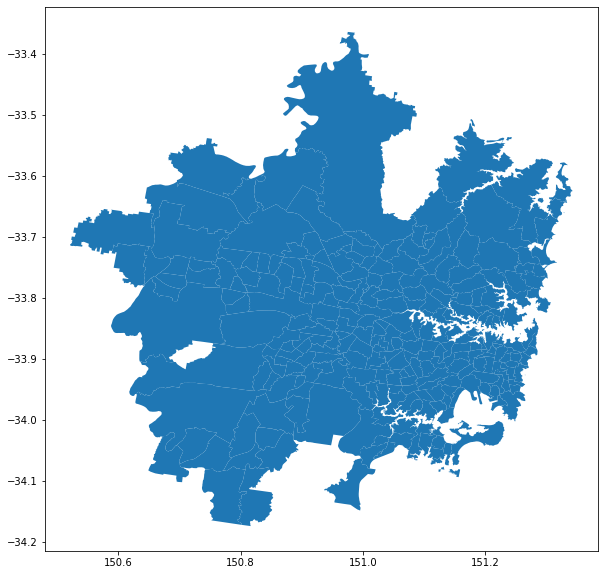

In [15]:
tracts.plot()

tracts.crs

In [16]:
# Create a geodataframe out of the grouped hex dataframe `df2`
gdf = myh3.df_with_hexid_to_gdf(df2, hexcolname='_id')

In [17]:
# Create a dataframe agg_gdf out of the tracts above and the geodataframe we created before 
agg_gdf = gpd.sjoin(gdf,tracts,how='inner',op='intersects')

In [23]:
# Generate a quick pivot table to see the different sums of each of the variables between the different periods
agg_gdf.pivot_table(index='standardized_types', 
                    columns='period', 
                    aggfunc={'nonresidents':sum,
                             'nonresidentsandnonneighbors':sum,
                             'residents':sum,
                             'totalcounts':sum,}, 
                    fill_value=0)

nonresidents                 \
period                                     0              1   
standardized_types                                            
Exclusive Dynamic              127275.720238   70161.904762   
Exclusive Static               164998.772619   89477.271429   
Low Income, At Risk of Change  174780.510714  112602.878571   
Low Income, Stable              31794.452381   16567.913095   
Low Income, Undergoing Change   74654.022619   40971.576190   

                              nonresidentsandnonneighbors                 \
period                                                  0              1   
standardized_types                                                         
Exclusive Dynamic                           117686.939286   65815.782143   
Exclusive Static                            150751.214286   83665.970238   
Low Income, At Risk of Change               157248.772619  105414.284524   
Low Income, Stable                           29206.640476   15513.972619   
Low Income, Undergoing Change                67936.791667   38553.902381   

                                  residents                  totalcounts  \
period                                    0             1              0   
standardized_types                                                         
Exclusive Dynamic              33324.826190  18619.360714  148108.354762   
Exclusive Static               48065.686905  26501.129762  195195.145238   
Low Income, At Risk of Change  42808.147619  21692.061905  201787.842857   
Low Income, Stable             11650.007143   6937.673810   37205.002381   
Low Income, Undergoing Change  28711.071429  15870.111905   89039.053571   

                                              
period                                     1  
standardized_types                            
Exclusive Dynamic               80156.721429  
Exclusive Static               105113.925000  
Low Income, At Risk of Change  125473.430952  
Low Income, Stable              19854.154762  
Low Income, Undergoing Change   47736.365476

In [24]:
agg_gdf.pivot_table(index='standardized_types', 
                    columns='period', 
                    aggfunc={'nonresidents':np.median,
                             'nonresidentsandnonneighbors':np.median,
                             'residents':np.median,
                             'totalcounts':np.median,}, 
                    fill_value=0)

nonresidents            \
period                                   0         1   
standardized_types                                     
Exclusive Dynamic                     3.00  2.142857   
Exclusive Static                      3.50  2.333333   
Low Income, At Risk of Change         7.75  3.285714   
Low Income, Stable                    3.00  1.937500   
Low Income, Undergoing Change         6.25  2.857143   

                              nonresidentsandnonneighbors           residents  \
period                                                  0         1         0   
standardized_types                                                              
Exclusive Dynamic                                    3.00  2.000000  8.285714   
Exclusive Static                                     3.25  2.166667  9.125000   
Low Income, At Risk of Change                        7.00  3.000000  9.600000   
Low Income, Stable                                   2.75  1.833333  8.666667   
Low Income, Undergoing Change                        5.75  2.666667  9.000000   

                                        totalcounts            
period                                1           0         1  
standardized_types                                             
Exclusive Dynamic              6.000000    3.428571  2.333333  
Exclusive Static               6.333333    4.000000  2.571429  
Low Income, At Risk of Change  6.500000    9.375000  3.714286  
Low Income, Stable             6.000000    3.375000  2.000000  
Low Income, Undergoing Change  6.142857    7.571429  3.250000

In [41]:
agg_group = agg_gdf[['nonresidents',
         'nonresidentsandnonneighbors',
                     'residents','totalcounts',
         'standardized_types','period']].groupby(['standardized_types','period']).agg(['mean',
                                            'median',
                                            'count',
                                            'sem'])
agg_group

nonresidents                            \
                                             mean    median count       sem   
standardized_types            period                                          
Exclusive Dynamic             0         24.970712  3.000000  5097  1.394364   
                              1         15.423589  2.142857  4549  0.876378   
Exclusive Static              0         26.265325  3.500000  6282  1.340348   
                              1         15.601965  2.333333  5735  0.843275   
Low Income, At Risk of Change 0         48.175444  7.750000  3628  3.846773   
                              1         33.147742  3.285714  3397  5.575426   
Low Income, Stable            0         11.629280  3.000000  2734  0.560635   
                              1          7.044181  1.937500  2352  0.526365   
Low Income, Undergoing Change 0         20.929078  6.250000  3567  0.883968   
                              1         12.241284  2.857143  3347  0.989154   

                                     nonresidentsandnonneighbors            \
                                                            mean    median   
standardized_types            period                                         
Exclusive Dynamic             0                        23.166720  3.000000   
                              1                        14.503257  2.000000   
Exclusive Static              0                        24.066286  3.250000   
                              1                        14.657668  2.166667   
Low Income, At Risk of Change 0                        43.402918  7.000000   
                              1                        31.104835  3.000000   
Low Income, Stable            0                        10.749592  2.750000   
                              1                         6.627071  1.833333   
Low Income, Undergoing Change 0                        19.131735  5.750000   
                              1                        11.550001  2.666667   

                                                      residents            \
                                     count       sem       mean    median   
standardized_types            period                                        
Exclusive Dynamic             0       5080  1.302410  24.813720  8.285714   
                              1       4538  0.835165  19.682199  6.000000   
Exclusive Static              0       6264  1.229941  27.419103  9.125000   
                              1       5708  0.800123  22.728242  6.333333   
Low Income, At Risk of Change 0       3623  3.470722  32.430415  9.600000   
                              1       3389  5.511123  28.025920  6.500000   
Low Income, Stable            0       2717  0.531791  20.190654  8.666667   
                              1       2341  0.503270  22.746472  6.000000   
Low Income, Undergoing Change 0       3551  0.812374  25.251602  9.000000   
                              1       3338  0.984905  25.311183  6.142857   

                                                     totalcounts            \
                                     count       sem        mean    median   
standardized_types            period                                         
Exclusive Dynamic             0       1343  2.269640   28.927413  3.428571   
                              1        946  2.003655   17.539764  2.333333   
Exclusive Static              0       1753  1.671480   31.017821  4.000000   
                              1       1166  2.300370   18.258455  2.571429   
Low Income, At Risk of Change 0       1320  2.175362   55.512474  9.375000   
                              1        774  3.135122   36.828128  3.714286   
Low Income, Stable            0        577  1.486049   13.563617  3.375000   
                              1        305  3.742126    8.402097  2.000000   
Low Income, Undergoing Change 0       1137  1.821787   24.933927  7.571429   
                              1        627  3.384282   1

In [51]:
agg_group.reset_index(inplace=True)

In [52]:
agg_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   (standardized_types, )                 10 non-null     object 
 1   (period, )                             10 non-null     int64  
 2   (nonresidents, mean)                   10 non-null     float64
 3   (nonresidents, median)                 10 non-null     float64
 4   (nonresidents, count)                  10 non-null     int64  
 5   (nonresidents, sem)                    10 non-null     float64
 6   (nonresidentsandnonneighbors, mean)    10 non-null     float64
 7   (nonresidentsandnonneighbors, median)  10 non-null     float64
 8   (nonresidentsandnonneighbors, count)   10 non-null     int64  
 9   (nonresidentsandnonneighbors, sem)     10 non-null     float64
 10  (residents, mean)                      10 non-null     float64
 11  (resident

In [34]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

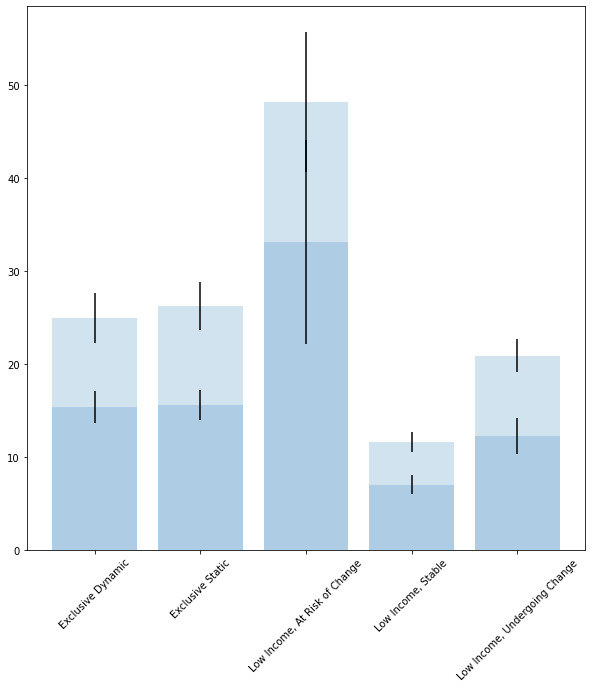

In [53]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(agg_group.standardized_types, 
       agg_group['nonresidents','mean'], 
       yerr=1.96*agg_group['nonresidents','sem'], alpha=0.2)
plt.xticks(rotation=45)
plt.show()

In [54]:
import matplotlib.pyplot as plt

def barchart(tweets_tracts, metric, title):
    
    #Windsorizing series to tream outliers 
    tweets_tracts['nonresidents_dif']=tweets_tracts['nonresidents_dif'].clip(lower= -60, upper=1000)
    tweets_tracts['nonresidents_ch']=tweets_tracts['nonresidents_ch'].clip(upper=6)
    
    #tweets_tracts['nonresidents_ch'].hist()
    typo_stats=tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'standardized_types']].groupby('standardized_types').agg(['mean','count','sem','std'])
    
    typo_stats=typo_stats.reset_index()
    
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON_POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='OTHER']
    
    
    #Sorting 
    typo_stats=typo_stats.sort_values(by=(metric,'mean'), ascending=False)
    
    fig, ax = plt.subplots()
    ax.bar(typo_stats['standardized_types'], typo_stats[metric,'mean'], yerr=1.96*typo_stats[metric,'sem'], alpha=0.2)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

## Update bounding box to only include City of Sydney proper 

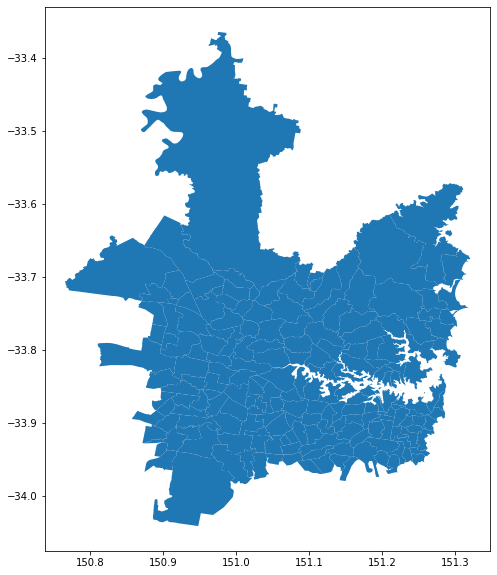

In [59]:
tracts.cx[150.9:151.3, -33.7:-33.95].plot()

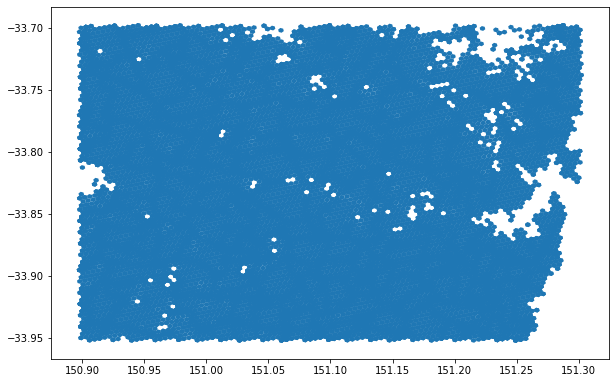

In [60]:
# create bounding box for new spatial analysis 
agg_gdf_new = agg_gdf.cx[150.9:151.3, -33.70:-33.95].plot()